# Learning LoRA
## Why implement LoRa
I want to make an any-to-any model. When I first completed it, I found that text-to-image was not accurate enough. If I use model fine-tuning and LoRA technology, there will be an improvement.

## Library import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import matplotlib.pyplot as plt

import math

## Implement LoRA 
The core principle of LoRA (Low-Rank Adaptation) is:
- Replace some weight matrices of the model with the product of two low-rank matrices:
𝑊 → 𝑊 + 𝐵𝐴
- Original Weight Matrix: 𝑊 is stationary (frozen).
- Two newly added small matrices𝐵, 𝐴 are trainable and significantly smaller in size than the original matrix, achieving low-cost model fine-tuning.

In [2]:
class LoRALinear(nn.Module):
    def __init__(self, in_features, out_features, r):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.r = r

        # Original Weight Matrix
        self.weight = nn.Parameter(torch.randn(out_features, in_features), requires_grad = False)
        
        # LoRA Low-Rank Matrix
        self.A = nn.Parameter(torch.randn(r, in_features))
        self.B = nn.Parameter(torch.randn(out_features, r))

    def forward(self, x):
        # x: (batch, in_features)
        lora_update = (x @ self.A.T) @ self.B.T  # (batch, out_features)
        return x @ self.weight.T + lora_update

I set the initial values of the newly added matrix to values close to 0, ensuring that the initial fine-tuning has a very small disturbance on the original model. If these two initial values are too large, it may lead to a dramatic change in network output when fine-tuning begins, affecting training stability.

# Test if LoRA is effective

Epoch 1, Loss: 2378.99755859375
Epoch 2, Loss: 2353.518798828125
Epoch 3, Loss: 2328.27978515625
Epoch 4, Loss: 2303.28076171875
Epoch 5, Loss: 2278.52587890625
Epoch 6, Loss: 2254.017333984375
Epoch 7, Loss: 2229.756591796875
Epoch 8, Loss: 2205.746826171875
Epoch 9, Loss: 2181.990234375
Epoch 10, Loss: 2158.4873046875
Epoch 11, Loss: 2135.24072265625
Epoch 12, Loss: 2112.252197265625
Epoch 13, Loss: 2089.522705078125
Epoch 14, Loss: 2067.05224609375
Epoch 15, Loss: 2044.842529296875
Epoch 16, Loss: 2022.894775390625
Epoch 17, Loss: 2001.2080078125
Epoch 18, Loss: 1979.783203125
Epoch 19, Loss: 1958.6201171875
Epoch 20, Loss: 1937.718505859375
Epoch 21, Loss: 1917.0791015625
Epoch 22, Loss: 1896.6998291015625
Epoch 23, Loss: 1876.5810546875
Epoch 24, Loss: 1856.721435546875
Epoch 25, Loss: 1837.120361328125
Epoch 26, Loss: 1817.7757568359375
Epoch 27, Loss: 1798.6871337890625
Epoch 28, Loss: 1779.8531494140625
Epoch 29, Loss: 1761.2711181640625
Epoch 30, Loss: 1742.940673828125
Epoch 

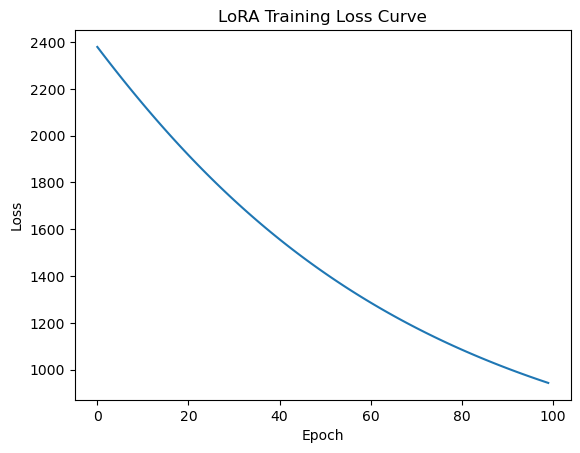

In [3]:
import torch
import matplotlib.pyplot as plt

lora_layer = LoRALinear(512, 512, r=4)
optimizer = torch.optim.Adam([lora_layer.A, lora_layer.B], lr=1e-3) 

# Simulate data
x = torch.randn(10, 512)
target = torch.randn(10, 512)
criterion = torch.nn.MSELoss()

losses = []
for epoch in range(100):
    optimizer.zero_grad()
    output = lora_layer(x)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Plot the loss curve
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LoRA Training Loss Curve')
plt.show()

## Issues discovered
The loss value initially starts high and decreases slowly (about 30 per round). Generally, an ideal training is for the loss to start low, rapidly decrease, and then stabilize.

## Why
- Because the data itself has no pattern to learn.
- Maybe weight initialization scale issue
- Maybe the learning rate or optimizer settings are not properly adjusted.

Epoch 1, Loss: 3271.427978515625
Epoch 2, Loss: 3242.877685546875
Epoch 3, Loss: 3214.565185546875
Epoch 4, Loss: 3186.495361328125
Epoch 5, Loss: 3158.66943359375
Epoch 6, Loss: 3131.0908203125
Epoch 7, Loss: 3103.76220703125
Epoch 8, Loss: 3076.685302734375
Epoch 9, Loss: 3049.863525390625
Epoch 10, Loss: 3023.2978515625
Epoch 11, Loss: 2996.99072265625
Epoch 12, Loss: 2970.943359375
Epoch 13, Loss: 2945.158203125
Epoch 14, Loss: 2919.634765625
Epoch 15, Loss: 2894.375244140625
Epoch 16, Loss: 2869.381591796875
Epoch 17, Loss: 2844.653564453125
Epoch 18, Loss: 2820.191162109375
Epoch 19, Loss: 2795.99560546875
Epoch 20, Loss: 2772.067138671875
Epoch 21, Loss: 2748.404541015625
Epoch 22, Loss: 2725.00927734375
Epoch 23, Loss: 2701.88037109375
Epoch 24, Loss: 2679.01708984375
Epoch 25, Loss: 2656.419189453125
Epoch 26, Loss: 2634.085693359375
Epoch 27, Loss: 2612.01611328125
Epoch 28, Loss: 2590.20849609375
Epoch 29, Loss: 2568.6630859375
Epoch 30, Loss: 2547.37744140625
Epoch 31, Loss

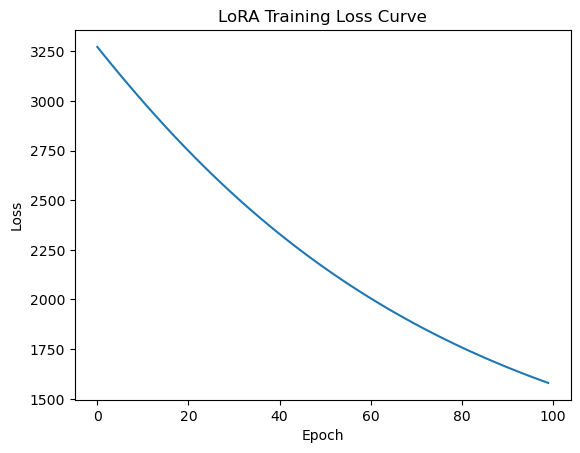

In [ ]:
# Verify hypothesis
import torch
import matplotlib.pyplot as plt

# Generate data with pattern
W_true = torch.randn(512, 512)
x = torch.randn(10, 512)
target = x @ W_true.T

lora_layer = LoRALinear(512, 512, r=4)
optimizer = torch.optim.Adam([lora_layer.A, lora_layer.B], lr=1e-3) 
criterion = torch.nn.MSELoss()

losses = []
for epoch in range(100):
    optimizer.zero_grad()
    output = lora_layer(x)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LoRA Training Loss Curve')
plt.show()

## How to improve
- Increase the rank (r) of LoRA
    For example, increase from r=4 to r=8 or r=16.
    The model's expressive ability increases, theoretically allowing it to more effectively approximate the true weights.

- Increase the learning rate or dynamically adjust
    For example, using CosineAnnealingLR can increase the convergence speed in the early stages.

- Increase the data size
    Currently, the data volume with only 10 samples is too small, and the data volume can be appropriately increased (such as more than 100 samples), which can better reflect the model's learning ability.
- Increase the number of training epochs

In [6]:
# Data construction
W_true = torch.randn(512, 512)
x = torch.randn(128, 512)
target = x @ W_true.T

# Model, optimizer, scheduler
model = LoRALinear(512, 512, r=4)
optimizer = torch.optim.Adam([model.A, model.B], lr=1e-2, weight_decay=1e-4)  # 启用正则
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-5)
criterion = nn.MSELoss()

# Warmup function
def warmup(epoch, warmup_epochs=5, base_lr=1e-2):
    if epoch < warmup_epochs:
        scale = (epoch + 1) / warmup_epochs
        for group in optimizer.param_groups:
            group["lr"] = base_lr * scale

# Training loop
losses, lrs = [], []

for epoch in range(100):
    model.train()
    warmup(epoch)

    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, target)

    # L2 regularization
    l2_loss = 0.01 * (model.A.norm(2) + model.B.norm(2))
    loss += l2_loss

    loss.backward()

    # Gradient clipping
    torch.nn.utils.clip_grad_norm_([model.A, model.B], max_norm=1.0)

    optimizer.step()
    scheduler.step(epoch + 1)

    # Log
    losses.append(loss.item())
    lrs.append(optimizer.param_groups[0]['lr'])
    print(f"Epoch {epoch+1:03d} | Loss: {loss.item():.2f} | LR: {lrs[-1]:.6f}")


Epoch 001 | Loss: 3316.51 | LR: 0.009756
Epoch 002 | Loss: 3293.58 | LR: 0.009046
Epoch 003 | Loss: 3248.28 | LR: 0.007941
Epoch 004 | Loss: 3181.72 | LR: 0.006549
Epoch 005 | Loss: 3095.51 | LR: 0.005005
Epoch 006 | Loss: 2991.72 | LR: 0.003461
Epoch 007 | Loss: 2941.40 | LR: 0.002069
Epoch 008 | Loss: 2907.22 | LR: 0.000964
Epoch 009 | Loss: 2887.04 | LR: 0.000254
Epoch 010 | Loss: 2877.69 | LR: 0.010000
Epoch 011 | Loss: 2875.23 | LR: 0.009939
Epoch 012 | Loss: 2780.64 | LR: 0.009756
Epoch 013 | Loss: 2690.55 | LR: 0.009456
Epoch 014 | Loss: 2605.80 | LR: 0.009046
Epoch 015 | Loss: 2527.03 | LR: 0.008537
Epoch 016 | Loss: 2454.70 | LR: 0.007941
Epoch 017 | Loss: 2389.05 | LR: 0.007273
Epoch 018 | Loss: 2330.19 | LR: 0.006549
Epoch 019 | Loss: 2278.11 | LR: 0.005786
Epoch 020 | Loss: 2232.66 | LR: 0.005005
Epoch 021 | Loss: 2193.62 | LR: 0.004224
Epoch 022 | Loss: 2160.67 | LR: 0.003461
Epoch 023 | Loss: 2133.45 | LR: 0.002737
Epoch 024 | Loss: 2111.53 | LR: 0.002069
Epoch 025 | Loss

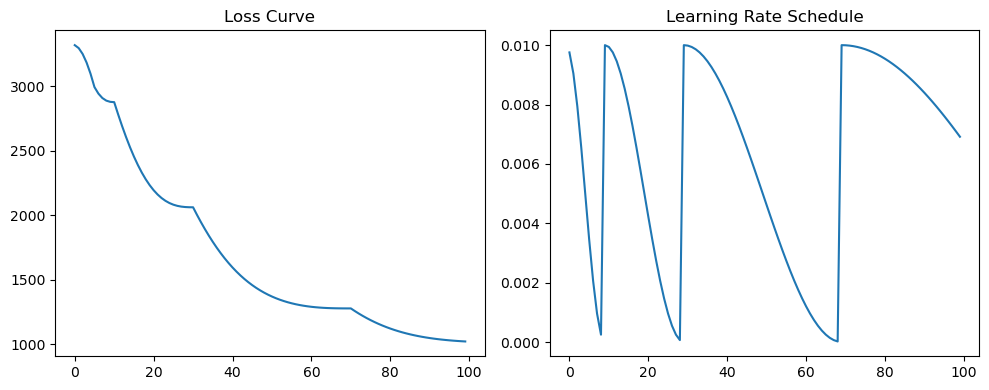

In [7]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(losses)
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(lrs)
plt.title("Learning Rate Schedule")

plt.tight_layout()
plt.show()


# Conclusion
An efficient parameter fine-tuning module based on LoRA is implemented, combined with the CosineAnnealingWarmRestarts dynamic learning rate scheduler and warmup strategy, effectively avoiding early stopping and improving convergence efficiency. Ultimately, under the condition of training only about 0.1% of the parameters, the loss is reduced from 3000+ to 1000+, verifying the effectiveness of the low-rank adapter structure.